# Mini Project

## Importing important libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from kmodes.kmodes import KModes # Now this line should work
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV



## Data Cleaning

In [2]:
df = pd.read_csv('cardio_train.csv', sep=';')

df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [4]:
print(df.isnull().sum())

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [5]:
df = df.drop('id', axis=1)

In [6]:
df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)
len(df)

60142

In [7]:
df[df['ap_lo']> df['ap_hi']].shape[0]

0

In [8]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000
mean,19468.719979,1.347311,164.554854,73.426805,125.770526,81.046307,1.350953,1.220229,0.085631,0.051877,0.803648,0.488228
std,2460.510296,0.476120,6.830174,11.614806,13.761847,8.239157,0.670076,0.567607,0.279820,0.221781,0.397241,0.499866
min,10798.000000,1.000000,150.000000,52.000000,100.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17677.250000,1.000000,160.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19705.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21321.000000,2.000000,169.000000,80.000000,135.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,180.000000,106.000000,163.000000,100.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
df['age'] = (df['age'] / 365).round().astype('int')

print(df.head())

   age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
0   50       2     168    62.0    110     80            1     1      0     0   
1   55       1     156    85.0    140     90            3     1      0     0   
2   52       1     165    64.0    130     70            3     1      0     0   
3   48       2     169    82.0    150    100            1     1      0     0   
4   48       1     156    56.0    100     60            1     1      0     0   

   active  cardio  
0       1       0  
1       1       1  
2       0       1  
3       1       1  
4       0       0  


## Features Exploration

In [10]:
# # Define the bin edges and labels
age_edges = [30, 35, 40, 45, 50, 55, 60, 65]
age_labels = [0, 1, 2, 3, 4, 5, 6]

#  bin in  5 years span
df['age_group'] = pd.cut(df['age'], bins=7, labels=range(7), include_lowest=True,right=True)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_group
0,50,2,168,62.0,110,80,1,1,0,0,1,0,3
1,55,1,156,85.0,140,90,3,1,0,0,1,1,4
2,52,1,165,64.0,130,70,3,1,0,0,0,1,4
3,48,2,169,82.0,150,100,1,1,0,0,1,1,3
4,48,1,156,56.0,100,60,1,1,0,0,0,0,3


In [11]:
df['bmi'] = df['weight']/((df['height']/100)**2)
df.head()

bmiMin = int(df['bmi'].min())
bmiMax = int(df['bmi'].max())

print(bmiMin, bmiMax)

df['bmi'] = pd.cut(df['bmi'], bins=6, labels=range(6), right=True, include_lowest=True)

df.head()


df["bmi"].value_counts(normalize=True)

16 46


bmi
1    0.461325
2    0.330202
3    0.133068
0    0.038193
4    0.033554
5    0.003658
Name: proportion, dtype: float64

In [12]:
df['map'] = ((2* df['ap_lo']) + df['ap_hi']) / 3

mapMin = int(df['map'].min())
mapMax = int(df['map'].max())

print(mapMin, mapMax)

df['map'] = pd.cut(df['map'], bins=6, labels=range(6), right=True, include_lowest=True)

df.head()

73 121


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_group,bmi,map
0,50,2,168,62.0,110,80,1,1,0,0,1,0,3,1,2
1,55,1,156,85.0,140,90,3,1,0,0,1,1,4,3,4
2,52,1,165,64.0,130,70,3,1,0,0,0,1,4,1,2
3,48,2,169,82.0,150,100,1,1,0,0,1,1,3,2,5
4,48,1,156,56.0,100,60,1,1,0,0,0,0,3,1,0


In [13]:
null_rows = df[df.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio, age_group, bmi, map]
Index: []


In [14]:
df_og=df

df=df.drop(['height','weight','ap_hi','ap_lo','age'],axis=1)

df.head()

,gender,cholesterol,gluc,smoke,alco,active,cardio,age_group,bmi,map
0,2,1,1,0,0,1,0,3,1,2
1,1,3,1,0,0,1,1,4,3,4
2,1,3,1,0,0,0,1,4,1,2
3,2,1,1,0,0,1,1,3,2,5
4,1,1,1,0,0,0,0,3,1,0


In [15]:
le = preprocessing.LabelEncoder()
df = df.apply(le.fit_transform)
df.describe()

,gender,cholesterol,gluc,smoke,alco,active,cardio,age_group,bmi,map
count,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000
mean,0.347311,0.350953,0.220229,0.085631,0.051877,0.803648,0.488228,4.042233,1.673440,2.359449
std,0.476120,0.670076,0.567607,0.279820,0.221781,0.397241,0.499866,1.377070,0.898707,1.186906
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000,2.000000,2.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.000000,2.000000,3.000000
max,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,6.000000,5.000000,5.000000


In [16]:
cost = []
num_clusters = range(1,6) # 1 to 5
for i in list(num_clusters):
    kmode = KModes(n_clusters=i, init = "Huang", n_init = 5, verbose=0,random_state=1)
    kmode.fit_predict(df)
    cost.append(kmode.cost_)

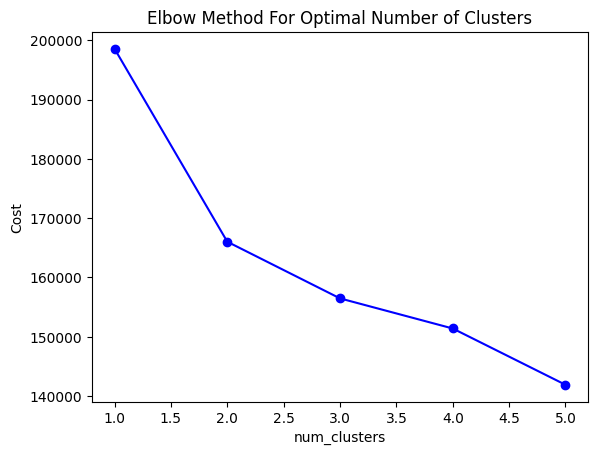

In [17]:
plt.plot(num_clusters, cost, 'bo-')
plt.xlabel('num_clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

In [18]:
km = KModes(n_clusters=2, init = "Huang", n_init = 5,random_state=1)
clusters = km.fit_predict(df)
clusters

array([1, 0, 1, ..., 1, 0, 1], dtype=uint16)

In [19]:
df.insert(0,"clusters",clusters,True)

df.head()

,clusters,gender,cholesterol,gluc,smoke,alco,active,cardio,age_group,bmi,map
0,1,1,0,0,0,0,1,0,3,1,2
1,0,0,2,0,0,0,1,1,4,3,4
2,1,0,2,0,0,0,0,1,4,1,2
3,0,1,0,0,0,0,1,1,3,2,5
4,1,0,0,0,0,0,0,0,3,1,0


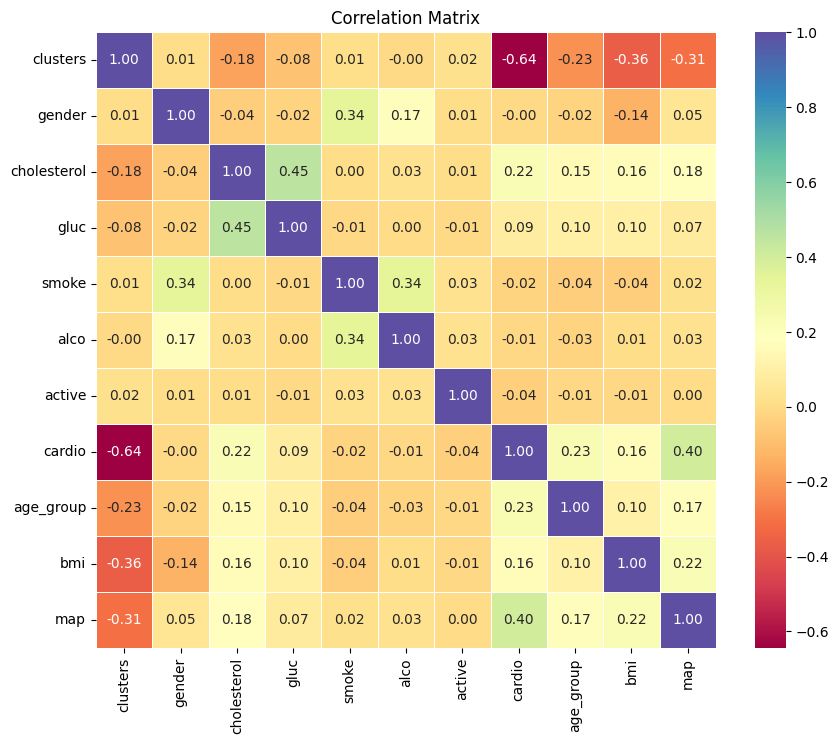

In [20]:
# Set up figure
plt.figure(figsize=(10, 8))

# Draw correlation matrix
sns.heatmap(df.corr(), annot=True, cmap='Spectral', fmt=".2f", linewidths=.5)

# Show the figure
plt.title('Correlation Matrix')
plt.show()

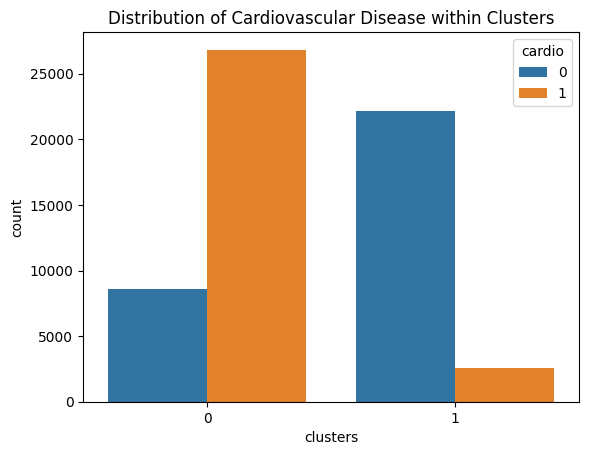

In [21]:
sns.countplot(x='clusters', hue='cardio', data=df)
plt.title('Distribution of Cardiovascular Disease within Clusters')
plt.show()

In [22]:
x = df.drop(['cardio','gender','alco'], axis=1)
y = df['cardio']

x.head()

,clusters,cholesterol,gluc,smoke,active,age_group,bmi,map
0,1,0,0,0,1,3,1,2
1,0,2,0,0,1,4,3,4
2,1,2,0,0,0,4,1,2
3,0,0,0,0,1,3,2,5
4,1,0,0,0,0,3,1,0


In [23]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=1)

In [24]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48113 entries, 20655 to 38356
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   clusters     48113 non-null  uint16
 1   cholesterol  48113 non-null  int64 
 2   gluc         48113 non-null  int64 
 3   smoke        48113 non-null  int64 
 4   active       48113 non-null  int64 
 5   age_group    48113 non-null  int64 
 6   bmi          48113 non-null  int64 
 7   map          48113 non-null  int64 
dtypes: int64(7), uint16(1)
memory usage: 3.0 MB


In [25]:
# build the model
rfModel = RandomForestClassifier(random_state=1)

# Fit the model
rfModel.fit(x_train, y_train)

# Make predictions
rf_pred = rfModel.predict(x_test)

# accuracy
rf_accuracy = metrics.accuracy_score(y_test, rf_pred)*100
print(f"Accuracy without CV: {rf_accuracy:.2f}")

Accuracy without CV: 87.49


In [26]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
}

#  Best parameters for RF
rf_best_params = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [10],
    'min_samples_leaf': [1],
    'max_features': [None],
}

# Create grid search
rf_gridsearch = GridSearchCV(estimator=rfModel,param_grid=rf_best_params, cv=5, scoring='accuracy',n_jobs=-1)

# Fit grid search
rf_gridsearch.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [10], 'max_features': [None],
                         'min_samples_leaf': [1], 'min_samples_split': [10],
                         'n_estimators': [100]},
             scoring='accuracy')

In [27]:
best_params = rf_gridsearch.best_params_
best_estimator = rf_gridsearch.best_estimator_

print(f"Best Parameters : {best_params}")
print(f"Best Estimator  : {best_estimator}")

Best Parameters : {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best Estimator  : RandomForestClassifier(max_depth=10, max_features=None, min_samples_split=10,
                       random_state=1)


In [28]:
rf_pred_CV = best_estimator.predict(x_test)


In [29]:
rf_accuracy_cv = metrics.accuracy_score(y_test, rf_pred_CV)*100
print(f"Best Accuracy: {rf_accuracy_cv:.2f}")

Best Accuracy: 87.82


In [30]:
print(f"Random Forest accuracy without CV : {rf_accuracy:.2f}")
print(f"Random Forest accuracy with CV    : {rf_accuracy_cv:.2f}")

Random Forest accuracy without CV : 87.49
Random Forest accuracy with CV    : 87.82


In [31]:
classification_report_str = classification_report(y_test, rf_pred_CV, digits=4)

print("Classification Report for RF with CV:\n", classification_report_str)

Classification Report for RF with CV:
               precision    recall  f1-score   support

           0     0.8837    0.8804    0.8820      6220
           1     0.8724    0.8759    0.8742      5809

    accuracy                         0.8782     12029
   macro avg     0.8780    0.8781    0.8781     12029
weighted avg     0.8782    0.8782    0.8782     12029



Text(0.5, 427.9555555555555, 'Predicted label')

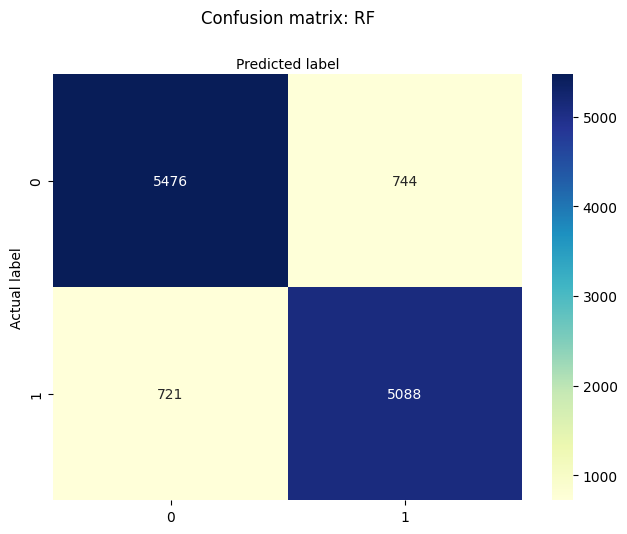

In [32]:
cnf_matrix = metrics.confusion_matrix(y_test, rf_pred_CV)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix: RF', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [33]:
# build MLP model
mlpModel = MLPClassifier(random_state=1)

# Fit the model
mlpModel.fit(x_train, y_train)

# Make predictions
mlp_pred = mlpModel.predict(x_test)

# accuracy
mlp_accuracy = metrics.accuracy_score(y_test, mlp_pred)*100
print(f"Accuracy without CV: {mlp_accuracy:.2f}")

Accuracy without CV: 87.28


c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [34]:
# Best parameters for MLP
mlp_best_params = {
    'activation': ['tanh'],
    'alpha': [0.01],
    'hidden_layer_sizes': [(50, 50)],
    'max_iter': [300],
    'solver': ['adam'],
}

# Create grid search
mlp_gridsearch = GridSearchCV(estimator=mlpModel, param_grid=mlp_best_params, cv=5, scoring='accuracy', n_jobs=-1)

# Fit grid search
mlp_gridsearch.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=1), n_jobs=-1,
             param_grid={'activation': ['tanh'], 'alpha': [0.01],
                         'hidden_layer_sizes': [(50, 50)], 'max_iter': [300],
                         'solver': ['adam']},
             scoring='accuracy')

In [35]:
# mlp_best_params = mlp_gridsearch.best_params_
mlp_best_estimator = mlp_gridsearch.best_estimator_

print(f"Best Parameters : {mlp_best_params}")
print(f"Best Estimator  : {mlp_best_estimator}")

Best Parameters : {'activation': ['tanh'], 'alpha': [0.01], 'hidden_layer_sizes': [(50, 50)], 'max_iter': [300], 'solver': ['adam']}
Best Estimator  : MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(50, 50),
              max_iter=300, random_state=1)


In [36]:
mlp_pred_CV = mlp_best_estimator.predict(x_test)

In [37]:
mlp_accuracy_cv = metrics.accuracy_score(y_test, mlp_pred_CV)*100
print(f"Best Accuracy: {mlp_accuracy_cv:.2f}")

Best Accuracy: 87.77


In [38]:
print(f"MLP accuracy without CV : {mlp_accuracy:.2f}")
print(f"MLP accuracy with CV    : {mlp_accuracy_cv:.2f}")

MLP accuracy without CV : 87.28
MLP accuracy with CV    : 87.77


In [39]:
classification_report_str = classification_report(y_test, mlp_pred_CV, digits=4)

print("Classification Report for MLP with CV:\n", classification_report_str)

Classification Report for MLP with CV:
               precision    recall  f1-score   support

           0     0.8875    0.8743    0.8809      6220
           1     0.8675    0.8814    0.8744      5809

    accuracy                         0.8777     12029
   macro avg     0.8775    0.8778    0.8776     12029
weighted avg     0.8779    0.8777    0.8777     12029



Text(0.5, 427.9555555555555, 'Predicted label')

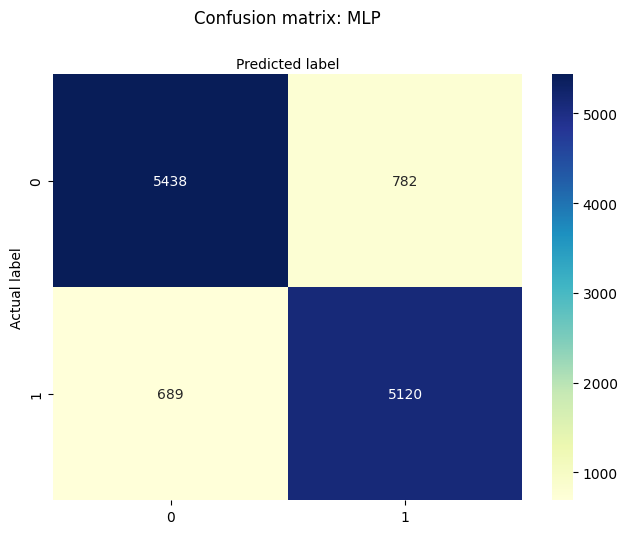

In [40]:
cnf_matrix = metrics.confusion_matrix(y_test, mlp_pred_CV)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix: MLP', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [41]:
# build SVM model
svmModel = SVC(random_state=1,probability=True)

# Fit the model
svmModel.fit(x_train, y_train)

# Make predictions
svm_pred = mlpModel.predict(x_test)

# accuracy
svm_accuracy = metrics.accuracy_score(y_test, svm_pred)*100
print(f"Accuracy without CV: {svm_accuracy:.2f}")

Accuracy without CV: 87.28


In [42]:
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
}

svm_best_params = {
    'C': [10],
    'kernel': ['rbf'],
    'gamma': ['auto'],
}

# Create grid search
svm_gridsearch = GridSearchCV(estimator=svmModel, param_grid=svm_best_params, cv=5, scoring='accuracy', n_jobs=-1)

# Fit grid search
svm_gridsearch.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=1), n_jobs=-1,
             param_grid={'C': [10], 'gamma': ['auto'], 'kernel': ['rbf']},
             scoring='accuracy')

In [43]:
svm_best_params = svm_gridsearch.best_params_
svm_best_estimator = svm_gridsearch.best_estimator_

print(f"Best Parameters : {svm_best_params}")
print(f"Best Estimator  : {svm_best_estimator}")

Best Parameters : {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Estimator  : SVC(C=10, gamma='auto', probability=True, random_state=1)


In [44]:
svm_pred_CV = svm_best_estimator.predict(x_test)

In [45]:
svm_accuracy_cv = metrics.accuracy_score(y_test, svm_pred_CV)*100
print(f"Best Accuracy: {svm_accuracy_cv:.2f}")

Best Accuracy: 88.01


In [46]:
print(f"SVM accuracy without CV : {svm_accuracy:.2f}")
print(f"SVM accuracy with CV    : {svm_accuracy_cv:.2f}")

SVM accuracy without CV : 87.28
SVM accuracy with CV    : 88.01


In [47]:
classification_report_str = classification_report(y_test, svm_pred_CV, digits=4)

print("Classification Report for SVM with CV:\n", classification_report_str)

Classification Report for SVM with CV:
               precision    recall  f1-score   support

           0     0.8729    0.8990    0.8858      6220
           1     0.8883    0.8599    0.8739      5809

    accuracy                         0.8801     12029
   macro avg     0.8806    0.8795    0.8798     12029
weighted avg     0.8804    0.8801    0.8800     12029



Text(0.5, 427.9555555555555, 'Predicted label')

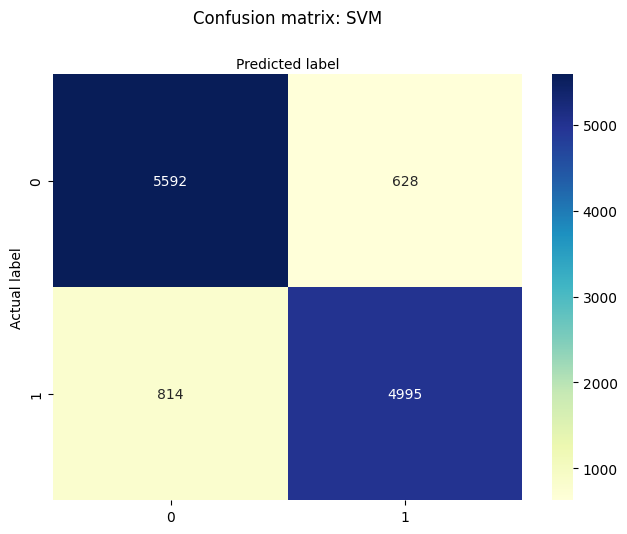

In [48]:
cnf_matrix = metrics.confusion_matrix(y_test, svm_pred_CV)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix: SVM', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Best Parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best Estimator for XGBoost: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)
Best Accuracy with XGBoost: 87.77
Classification Report for XGBoost with CV:
              

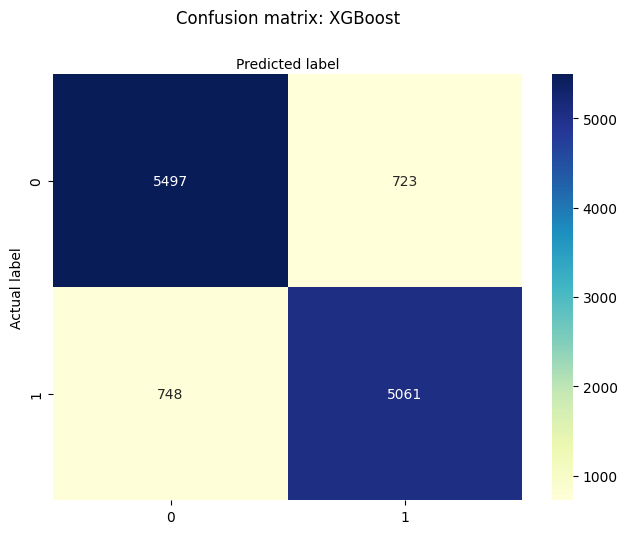

In [49]:
from xgboost import XGBClassifier

# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create the XGBoost model
xgb_model = XGBClassifier(random_state=1)

# Create grid search
xgb_gridsearch = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit grid search
xgb_gridsearch.fit(x_train, y_train)

# Get the best parameters and estimator
xgb_best_params = xgb_gridsearch.best_params_
xgb_best_estimator = xgb_gridsearch.best_estimator_

print(f"Best Parameters for XGBoost: {xgb_best_params}")
print(f"Best Estimator for XGBoost: {xgb_best_estimator}")

# Make predictions with the best estimator
xgb_pred_CV = xgb_best_estimator.predict(x_test)

# Calculate accuracy
xgb_accuracy_cv = metrics.accuracy_score(y_test, xgb_pred_CV) * 100
print(f"Best Accuracy with XGBoost: {xgb_accuracy_cv:.2f}")

# Classification report for XGBoost
classification_report_xgb = classification_report(y_test, xgb_pred_CV, digits=4)
print("Classification Report for XGBoost with CV:\n", classification_report_xgb)

# Confusion matrix for XGBoost
cnf_matrix_xgb = metrics.confusion_matrix(y_test, xgb_pred_CV)
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(cnf_matrix_xgb), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix: XGBoost', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [50]:
xgb_accuracy_cv = metrics.accuracy_score(y_test, xgb_pred_CV) * 100
print(f"Best Accuracy with XGBoost: {xgb_accuracy_cv:.2f}")

Best Accuracy with XGBoost: 87.77
